# Trash Classification Project

## 1. Problem Understanding and Justification

**Objective**: Develop a CNN model to classify images of trash into specific categories using the "TrashNet" dataset.

**Justification**: Convolutional Neural Networks (CNNs) are ideal for image classification because they capture spatial hierarchies and visual patterns. Given the distinct visual features of trash categories (e.g., colors, textures, shapes), CNNs can effectively recognize these differences for accurate classification.

---

## 2. Data Preparation

**Steps**:
   - **Load the Dataset**: Import and organize the TrashNet dataset into training, validation, and test sets.
   - **Preprocess Images**: 
      - Resize all images to a consistent input shape (224x224 pixels) required by MobileNetV2.
      - Normalize pixel values to speed up model convergence.
   - **Oversample Minority Class ("Trash")**: Increase the representation of the "Trash" class in the training set by oversampling to address class imbalance.
   - **Label Encoding**: Convert categorical labels to numerical form using sparse categorical encoding, suitable for multi-class classification.

**Additional Insights**:  
The TrashNet dataset may have an imbalanced class distribution, which could lead to model bias favoring certain classes. Oversampling the "Trash" class helps to mitigate this issue.

---

## 3. Model Architecture

**Choice of Model**: MobileNetV2 with a Custom Classification Head

   - **Base Model**: Use MobileNetV2, pre-trained on ImageNet, as a feature extractor. MobileNetV2 is efficient and optimized for mobile applications, ideal for projects that may require deployment on resource-constrained devices.
   - **Freeze Layers**: Freeze the MobileNetV2 layers to retain learned features, speed up training, and avoid overfitting on a relatively small dataset.
   - **Add a Custom Classification Head**:
      - Apply **Global Average Pooling** to reduce spatial dimensions while retaining essential features.
      - Add a **Dense Layer** with 128 neurons and ReLU activation to learn specific trash image patterns.
      - Include a **Dropout Layer** with a 50% rate to prevent overfitting by randomly omitting neuron connections during training.
      - Final **Output Layer**: Add a Dense layer with softmax activation to classify images into six categories (one for each trash type).

**Pros**:
   - **Pre-Trained Feature Extraction**: Leveraging MobileNetV2 accelerates training and improves accuracy since the model already has a general understanding of image features.
   - **Regularization**: The dropout layer reduces the risk of overfitting, especially beneficial when using a smaller dataset.

**Cons**:
   - **Model Size**: Even though MobileNetV2 is efficient, it may still require optimization for edge device deployment.
   - **Frozen Layers Limitation**: While freezing layers helps retain general features, it may limit the model’s ability to learn specific patterns unique to the TrashNet dataset.

---

## 4. Model Compilation

   - **Loss Function**: Use `sparse_categorical_crossentropy`, suitable for multi-class classification with integer-encoded labels.
   - **Optimizer**: Adam optimizer is chosen for its adaptive learning rate properties, facilitating efficient convergence.
   - **Metrics**: Track accuracy during training but consider adding precision, recall, and F1-score during evaluation for a nuanced view of classification errors.

---

## 5. Model Training

   - **Epochs**: Train the model for 20 epochs to allow sufficient learning without risking prolonged overfitting.
   - **Validation Data**: Use a separate validation set to monitor accuracy and generalization on unseen data.
   - **Tracking with W&B**: Track metrics like accuracy, loss, and epoch performance via Weights & Biases (W&B) using the `WandbMetricsLogger` callback. This integration allows for real-time performance monitoring, aiding in identifying potential training issues.

---

## Install and Import Libraries

In [117]:
!pip install huggingface_hub --q

In [111]:
!pip install --upgrade wandb

In [119]:
# Importing Libraries
import random
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from datasets import DatasetDict
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

from PIL import Image
from datasets import load_dataset

from huggingface_hub import login

In [6]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: syllg (syllg-institut-teknologi-bandung). Use `wandb login --relogin` to force relogin


True

In [27]:
# Load the dataset (Make sure the dataset path is correct in Kaggle)
dataset = load_dataset('/kaggle/input/trash-dataset', split='train')
dataset

Resolving data files:   0%|          | 0/2527 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 2527
})

# Exploratory Image Analysis

Class distribution with names:
 label
cardboard    403
glass        501
metal        410
paper        594
plastic      482
trash        137
Name: count, dtype: int64


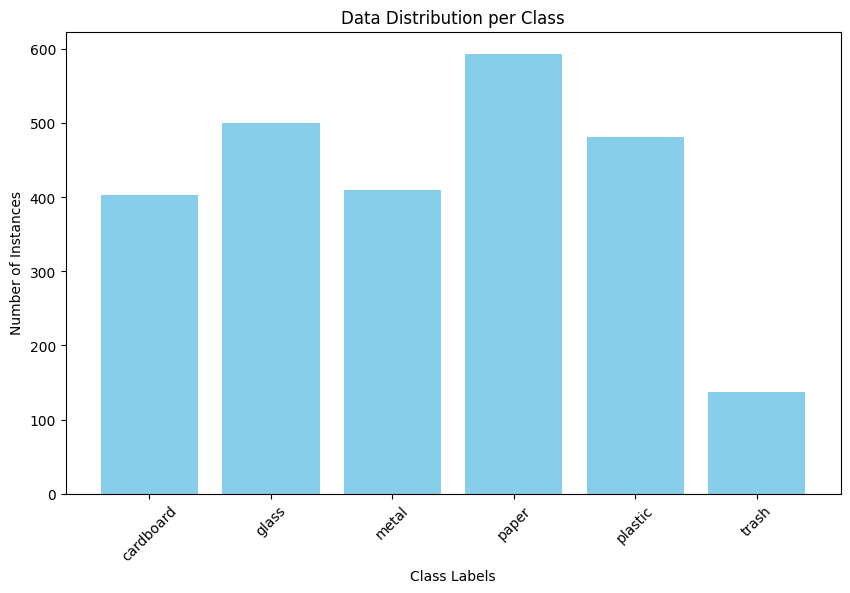

In [29]:
# Define a dictionary to map label indices to class names
label_mapping = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

# Convert the dataset to a DataFrame and count occurrences of each label
df = dataset.to_pandas()
label_counts = df['label'].value_counts().sort_index()
label_counts_named = label_counts.rename(index=label_mapping)

# Display the count of each class with label names
print("Class distribution with names:\n", label_counts_named)

# Plotting the class distribution
plt.figure(figsize=(10, 6))
plt.bar(label_counts_named.index, label_counts_named.values, color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Instances')
plt.title('Data Distribution per Class')
plt.xticks(rotation=45)
plt.show()

New class distribution after oversampling 'trash':
 label
paper        594
glass        501
plastic      482
trash        478
metal        410
cardboard    403
Name: count, dtype: int64


/tmp/ipykernel_585/4278195919.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(label_counts_original.index, rotation=45)
/tmp/ipykernel_585/4278195919.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(label_counts_balanced.index, rotation=45)


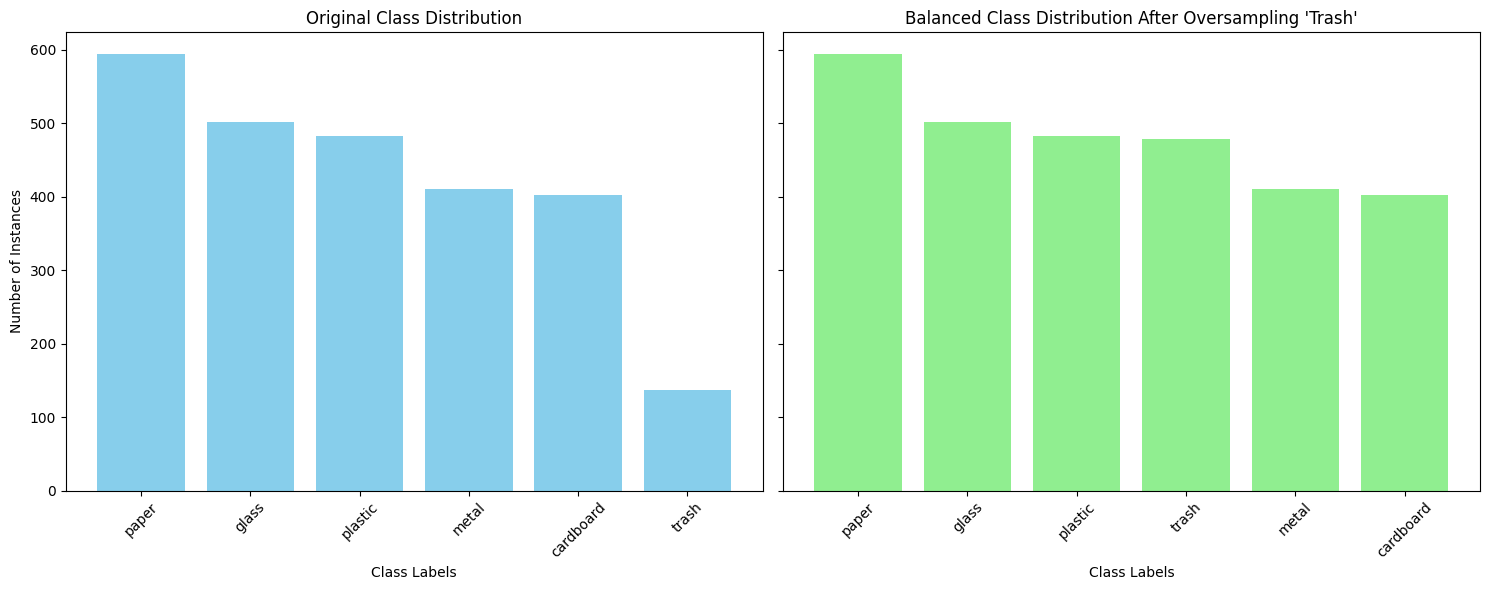

In [96]:
# Calculate the average count of non-trash classes
non_trash_avg_count = int(label_counts_named[label_counts_named.index != 'trash'].mean())

# Separate "trash" class and non-trash classes
trash_label_index = list(label_mapping.keys())[list(label_mapping.values()).index('trash')]
trash_df = df[df['label'] == trash_label_index]
non_trash_df = df[df['label'] != trash_label_index]

# Oversample "trash" class to match the average count of other classes
trash_oversampled_df = resample(trash_df, replace=True, n_samples=non_trash_avg_count, random_state=42)

# Concatenate oversampled "trash" class with non-trash classes and shuffle
balanced_df = pd.concat([non_trash_df, trash_oversampled_df], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new distribution after oversampling
print("New class distribution after oversampling 'trash':\n", balanced_df['label'].map(label_mapping).value_counts())

# Original class distribution before oversampling
label_counts_original = df['label'].map(label_mapping).value_counts()

# New class distribution after oversampling
label_counts_balanced = balanced_df['label'].map(label_mapping).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot original class distribution
axes[0].bar(label_counts_original.index, label_counts_original.values, color='skyblue')
axes[0].set_title("Original Class Distribution")
axes[0].set_xlabel("Class Labels")
axes[0].set_ylabel("Number of Instances")
axes[0].set_xticklabels(label_counts_original.index, rotation=45)

# Plot balanced class distribution
axes[1].bar(label_counts_balanced.index, label_counts_balanced.values, color='lightgreen')
axes[1].set_title("Balanced Class Distribution After Oversampling 'Trash'")
axes[1].set_xlabel("Class Labels")
axes[1].set_xticklabels(label_counts_balanced.index, rotation=45)

plt.tight_layout()
plt.show()

In [34]:
# Path to the dataset directory
root_dir = '/kaggle/input/trash-dataset/dataset-resized'

# Create empty lists to store image paths and labels
image_paths = []
labels = []

# Iterate through each subfolder (class) inside the root directory
for label in os.listdir(root_dir):
    label_dir = os.path.join(root_dir, label)
    
    # Only process directories (ensure it's a class folder)
    if os.path.isdir(label_dir):
        # Iterate through each image file in the label's directory
        for img_name in os.listdir(label_dir):
            # Get the full path to the image
            img_path = os.path.join(label_dir, img_name)
            
            # Append the image path and label to the lists
            image_paths.append(img_path)
            labels.append(label)  # Correct label assignment

# Create a DataFrame with the image paths and labels
image_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Check the first few rows of the DataFrame
print(image_df)

                                             image_path    label
0     /kaggle/input/trash-dataset/dataset-resized/me...    metal
1     /kaggle/input/trash-dataset/dataset-resized/me...    metal
2     /kaggle/input/trash-dataset/dataset-resized/me...    metal
3     /kaggle/input/trash-dataset/dataset-resized/me...    metal
4     /kaggle/input/trash-dataset/dataset-resized/me...    metal
...                                                 ...      ...
2522  /kaggle/input/trash-dataset/dataset-resized/pl...  plastic
2523  /kaggle/input/trash-dataset/dataset-resized/pl...  plastic
2524  /kaggle/input/trash-dataset/dataset-resized/pl...  plastic
2525  /kaggle/input/trash-dataset/dataset-resized/pl...  plastic
2526  /kaggle/input/trash-dataset/dataset-resized/pl...  plastic

[2527 rows x 2 columns]


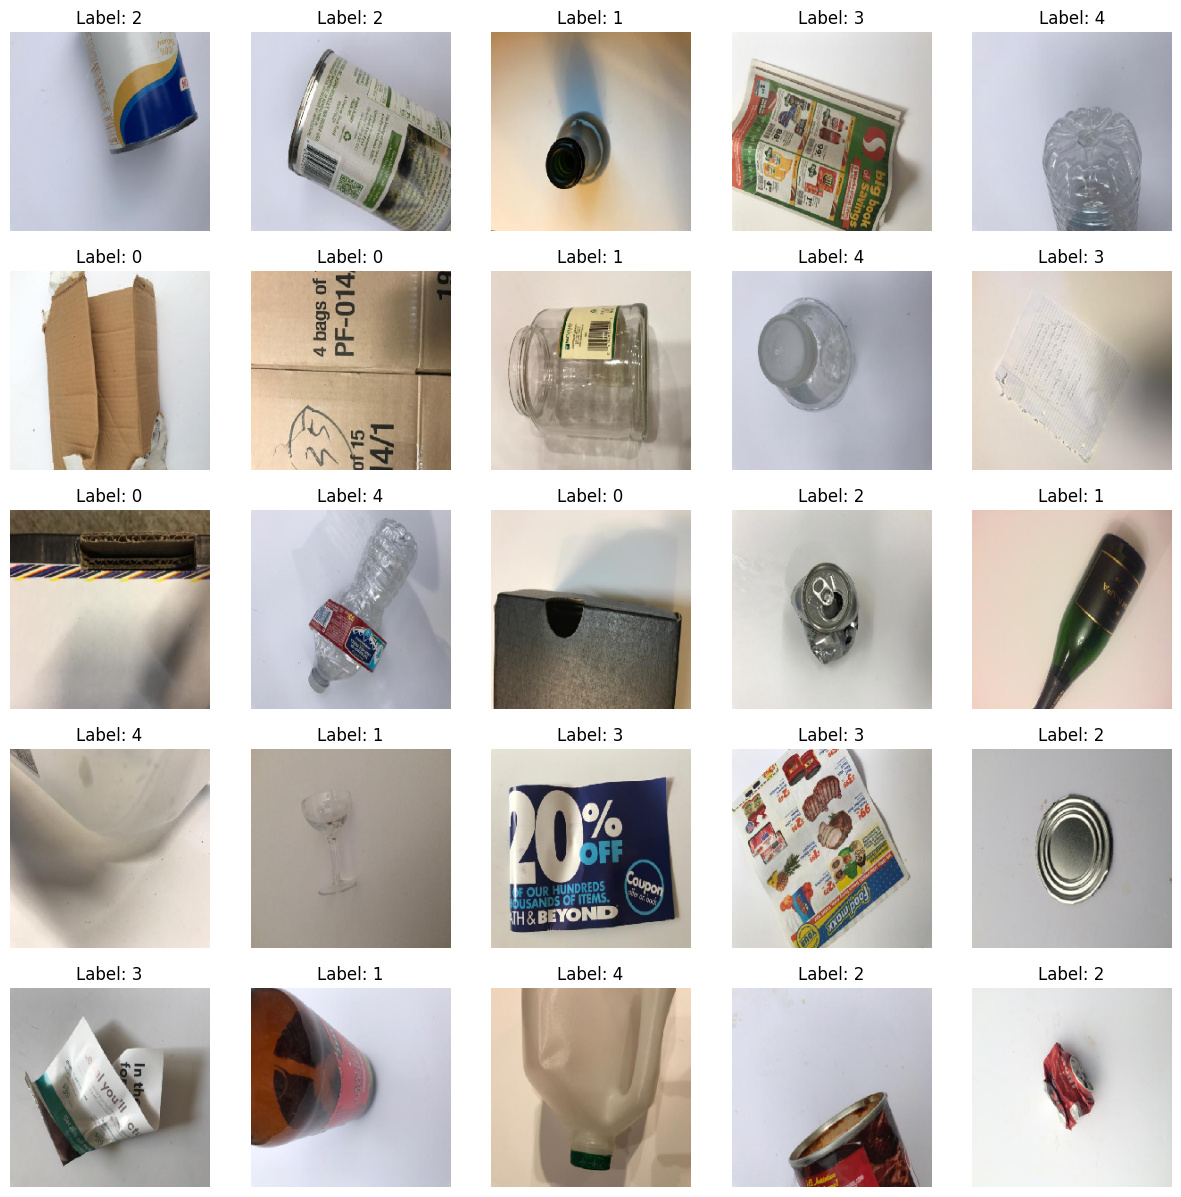

In [106]:
# Function to display random images from the dataset
def display_random_images(image_df, num_images=25):
    # Select random rows from the DataFrame
    random_rows = image_df.sample(n=num_images)
    
    # Set up the plot grid
    plt.figure(figsize=(15, 15))
    
    # Loop through the random images and display them
    for i, (index, row) in enumerate(random_rows.iterrows()):
        img_path = row['image_path']
        img = image.load_img(img_path, target_size=(224, 224))  # Load and resize image
        
        # Display the image
        plt.subplot(5, 5, i+1)
        plt.imshow(img)
        plt.title(f"Label: {row['label']}")
        plt.axis('off')
    
    plt.show()

# Display 10 random images from the dataset
display_random_images(image_df, num_images=25)


# Data Preparation

In [66]:
# Encode labels to numeric values
label_encoder = LabelEncoder()
image_df['label'] = label_encoder.fit_transform(image_df['label'])

# Split data into train, validation, and test sets (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(image_df['image_path'], image_df['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing function to load and resize images
def load_and_resize_image(img_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    return img_array

# Convert image paths to image arrays and labels to numpy arrays
train_images = np.array([load_and_resize_image(img_path) for img_path in X_train])
val_images = np.array([load_and_resize_image(img_path) for img_path in X_val])
test_images = np.array([load_and_resize_image(img_path) for img_path in X_test])

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Print shapes to verify
print(f"Train images shape: {train_images.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")


Train images shape: (2021, 224, 224, 3)
Validation images shape: (253, 224, 224, 3)
Test images shape: (253, 224, 224, 3)
Train labels shape: (2021,)
Validation labels shape: (253,)
Test labels shape: (253,)


# Model Training & Evaluation Analysis

In [92]:
# Initialize W&B run
wandb.init(project="trash-classification", entity="syllg-institut-teknologi-bandung")

# Load MobileNetV2 pre-trained on ImageNet without the top classification layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers
base_model.trainable = False

# Add custom classification head with dropout
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # 50% dropout rate
predictions = Dense(6, activation='softmax')(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define number of epochs
epochs = 20

# Train the model with Wandb callback
history = model.fit(
    train_images, y_train,
    epochs=epochs,
    validation_data=(val_images, y_val),
    callbacks=[wandb.keras.WandbMetricsLogger()]
)


# Finish the W&B run
wandb.finish()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_17[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.4624 - loss: 1.4335 - val_accuracy: 0.7510 - val_loss: 0.6646
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7504 - loss: 0.6792 - val_accuracy: 0.8063 - val_loss: 0.5726
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8023 - loss: 0.5561 - val_accuracy: 0.7984 - val_loss: 0.5627
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8372 - loss: 0.4362 - val_accuracy: 0.8300 - val_loss: 0.4853
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8584 - loss: 0.3942 - val_accuracy: 0.8538 - val_loss: 0.4913
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8946 - loss: 0.3096 - val_accuracy: 0.8617 - val_loss: 0.4560
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8937 - loss: 0.3036 - val_accuracy: 0.8538 - val_loss: 0.4540
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9260 - loss: 0.2288 - val_accuracy: 0.8577 -

epoch/accuracy,▁▄▅▅▆▆▆▇▇▇▇▇█▇██████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▄▆███████▇█▇▇▇▆███
epoch/val_loss,█▅▅▂▂▁▁▁▁▁▂▁▁▂▃▂▃▂▄▄
epoch/accuracy,0.97476
epoch/epoch,19
epoch/learning_rate,0.001
epoch/loss,0.07941
epoch/val_accuracy,0.85771


In [93]:
# Make predictions on the test set
y_pred = model.predict(test_images)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Get class names from label_encoder (ensure they're strings)
class_names = [str(label) for label in label_encoder.classes_]

# Generate the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 358ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           1       0.85      0.85      0.85        59
           2       0.77      0.97      0.86        37
           3       0.91      0.89      0.90        57
           4       0.88      0.77      0.82        48
           5       0.69      0.50      0.58        18

    accuracy                           0.85       253
   macro avg       0.83      0.82      0.82       253
weighted avg       0.85      0.85      0.85       253



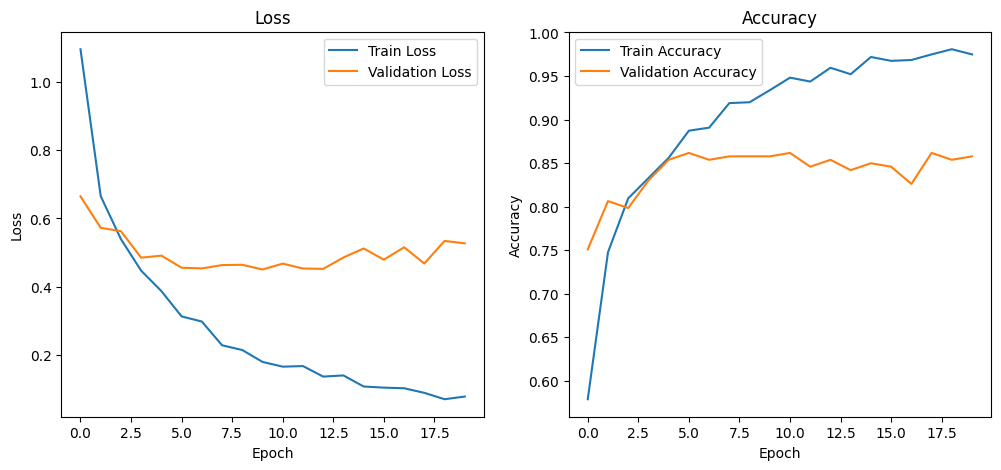

In [95]:
# Plot training & validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Finish the wandb run
wandb.finish()

# Save the Model

In [98]:
# Saving the trained model
model.save('trash_classification.h5')

# Additional Insights

## Insights from Classification Report

The classification report provides detailed insights into the model’s performance across six classes. The key metrics—precision, recall, and F1-score—indicate how well the model distinguishes between classes, and where it may need refinement. Here's a breakdown of the report:

### 1. Overall Accuracy
- **Accuracy**: The model achieves an overall accuracy of 85% across 253 samples, which indicates relatively strong performance in correctly predicting the classes.

### 2. Precision, Recall, and F1-Score Analysis
   - **Precision**: Measures how many of the predicted positive instances for each class are actually correct.
   - **Recall**: Assesses how many of the actual positive instances for each class are identified by the model.
   - **F1-Score**: A harmonic mean of precision and recall, providing a balanced metric for class performance.

### 3. Class-Specific Performance
- **Class 0** (Precision: 0.89, Recall: 0.94, F1-Score: 0.91):
  - High precision and recall indicate that the model is highly accurate in identifying Class 0 with minimal misclassification.

- **Class 1** (Precision: 0.85, Recall: 0.85, F1-Score: 0.85):
  - Consistent precision and recall scores indicate balanced performance for this class.

- **Class 2** (Precision: 0.77, Recall: 0.97, F1-Score: 0.86):
  - High recall but slightly lower precision suggests that Class 2 predictions include a few false positives, meaning some instances may be misclassified as Class 2.

- **Class 3** (Precision: 0.91, Recall: 0.89, F1-Score: 0.90):
  - Both precision and recall are high, indicating robust performance for this class, with few misclassifications.

- **Class 4** (Precision: 0.88, Recall: 0.77, F1-Score: 0.82):
  - Lower recall than precision suggests that some Class 4 instances may be misclassified into other classes. This is an area where the model could improve in correctly identifying Class 4.

- **Class 5** (Precision: 0.69, Recall: 0.50, F1-Score: 0.58):
  - This class has notably lower precision and recall, indicating significant misclassification. Class 5 predictions tend to include many false positives, and the model also fails to capture all true instances of Class 5.

### 4. Average Metrics
   - **Macro Average** (Precision: 0.83, Recall: 0.82, F1-Score: 0.82):
     - Averages performance equally across all classes, showing that overall precision and recall are fairly balanced but with room for improvement, especially in underrepresented classes.

   - **Weighted Average** (Precision: 0.85, Recall: 0.85, F1-Score: 0.85):
     - Weighted by class support, this metric reflects strong overall performance but highlights that certain classes, such as Class 5, could benefit from more targeted improvements.

### 5. Insights and Recommendations
   - **Class Imbalance**: The lower recall for Class 5 suggests that this minority class may need further data augmentation or oversampling. Adding more representative examples of Class 5 could help the model learn this class's characteristics more effectively.
   - **Misclassification in Class 2 and Class 4**: Precision dips for Classes 2 and 4 indicate occasional false positives, suggesting some overlap in features with other classes. Adjusting data preprocessing or adding fine-tuned class-specific layers may improve differentiation for these classes.
   - **Overall Robustness**: High F1-scores in most classes indicate robust performance, with Class 5 as the main outlier.

This analysis highlights areas where the model performs well and suggests targeted improvements, especially for minority classes like Class 5, to enhance overall classification accuracy and balance.
